<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/JARVIS_LAMMPS_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [1]:
!conda --version

conda 23.11.0


In [2]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


Install LAMMPS using conda. For details about installation, see: https://docs.lammps.org/Install.html

In [3]:
%%time
!conda install lammps jarvis-tools -y --quiet

Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - jarvis-tools
    - lammps


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ase-3.23.0                 |     pyhd8ed1ab_0         1.8 MB  conda-forge
    babel-2.14.0               |     pyhd8ed1ab_0         7.3 MB  conda-forge
    binutils_impl_linux-64-2.40|       hf600244_0         5.2 MB  conda-forge
    binutils_linux-64-2.40     |       hdade7a5_3          28 KB  conda-forge
    blinker-1.8.2              |     pyhd8ed1ab_0          14 KB  conda-forge
    blosc-1.21.5               |       hc2324a3_1          48 KB  conda-forge
    brotli-1.1.0               |       hd590300_1          19 KB  conda-forge
    brotli-bin-1.1.0           |       hd590300_1          19 KB  conda-forge
    ca-certificates-2024.6.2   |

Check LAMMPS is installed

In [ ]:
# !lmp -help

# Simulating a Lennard-Jones Fluid
This tutorial will guide you through setting up, running, and post-processing a simulation of a Lennard-Jones (LJ) fluid using LAMMPS. We'll cover:

1. Creating the input script for LAMMPS
2. Running the simulation
3. Post-processing the results with Python

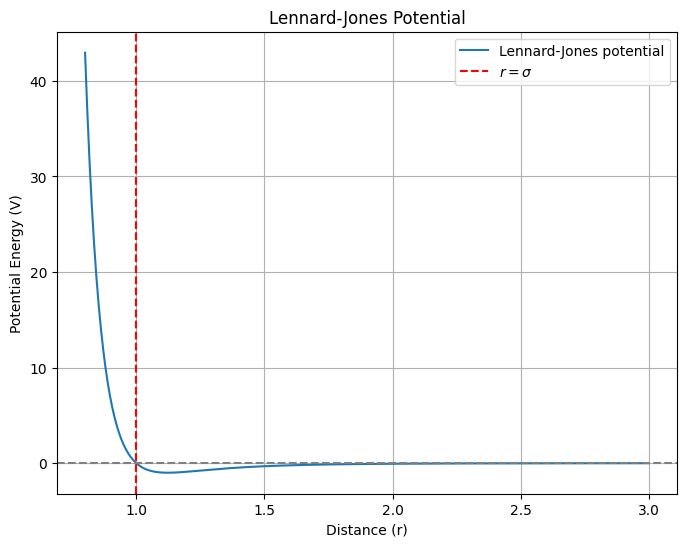

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Lennard-Jones potential
epsilon = 1.0  # Depth of the potential well
sigma = 1.0    # Distance at which the potential is zero

# Define the Lennard-Jones potential function
def lennard_jones(r, epsilon, sigma):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

# Generate a range of distances in 1D
r = np.linspace(0.8, 3.0, 500)

# Calculate the Lennard-Jones potential for each distance
V = lennard_jones(r, epsilon, sigma)

# Plot the Lennard-Jones potential
plt.figure(figsize=(8, 6))
plt.plot(r, V, label='Lennard-Jones potential')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(sigma, color='red', linestyle='--', label=r'$r = \sigma$')
plt.title('Lennard-Jones Potential')
plt.xlabel('Distance (r)')
plt.ylabel('Potential Energy (V)')
plt.legend()
plt.grid(True)
plt.show()


To run a simulation using LAMMPS, one needs to write a series of commands in an input script.

Let's run a benchmark problem from LAMMPS (https://github.com/lammps/lammps/blob/develop/bench/in.lj)

Documentation on lj/cut: https://docs.lammps.org/pair_lj.html

In [5]:
lammps_in = """# 3d Lennard-Jones melt

units           lj
atom_style      atomic

lattice         fcc 0.8442
region          box block 0 20 0 20 0 20
create_box      1 box
create_atoms    1 box
mass            1 1.0

velocity        all create 1.44 87287 loop geom

pair_style      lj/cut 2.5
pair_coeff      1 1 1.0 1.0 2.5

timestep        0.001
thermo          100

neighbor        0.3 bin
neigh_modify    delay 0 every 20 check no

fix             1 all nve

run             1000


write_dump all xyz system.xyz
"""
with open('lj_fluid.in', 'w') as f:
  f.write(lammps_in)

In [6]:
%%time
!lmp -in lj_fluid.in

LAMMPS (7 Feb 2024 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 1.6795962 1.6795962 1.6795962
Created orthogonal box = (0 0 0) to (33.591924 33.591924 33.591924)
  1 by 1 by 1 MPI processor grid
Created 32000 atoms
  using lattice units in orthogonal box = (0 0 0) to (33.591924 33.591924 33.591924)
  create_atoms CPU = 0.004 seconds
Generated 0 of 0 mixed pair_coeff terms from geometric mixing rule
Neighbor list info ...
  update: every = 20 steps, delay = 0 steps, check = no
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 2.8
  ghost atom cutoff = 2.8
  binsize = 1.4, bins = 24 24 24
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair lj/cut, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : lj
  Curre

Exercise: Parse log.lammps and make plots

Now lets run this example using PyLammps

In [7]:
#https://github.com/lammps/lammps/blob/develop/python/examples/pylammps/simple.ipynb
from lammps import IPyLammps
L = IPyLammps()
# 3d Lennard-Jones melt

L.units("lj")
L.atom_style("atomic")

L.lattice("fcc", 0.8442)
L.region("box", "block", 0, 20, 0, 20, 0, 20)
L.create_box(1, "box")
L.create_atoms(1, "box")
L.mass(1, 1.0)



L.pair_style("lj/cut", 2.5)
L.pair_coeff(1, 1, 1.0, 1.0, 2.5)
# L.pair_style("lj/gromacs", 3.5, 4.5)
# L.pair_coeff(1, 1, 1.0, 1.0)



L.timestep(0.001)
L.thermo(100)
L.neighbor(0.3, "bin")
L.neigh_modify("delay", 0, "every", 20, "check no")

L.fix("1", "all", "nve")



LAMMPS output is captured by PyLammps wrapper


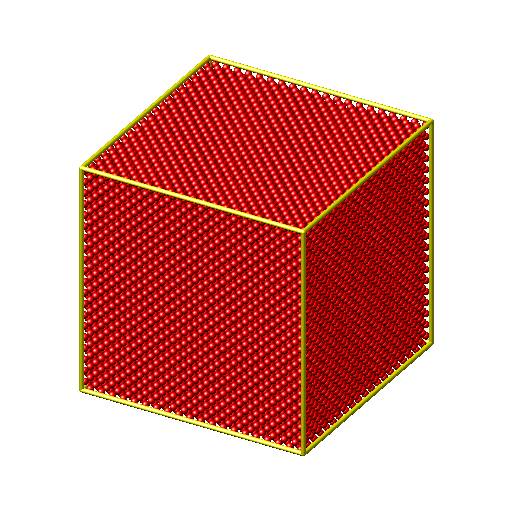

In [8]:
L.image(zoom=1.0)

In [9]:
L.run(1000)

['Generated 0 of 0 mixed pair_coeff terms from geometric mixing rule',
 'Neighbor list info ...',
 '  update: every = 20 steps, delay = 0 steps, check = no',
 '  max neighbors/atom: 2000, page size: 100000',
 '  master list distance cutoff = 2.8',
 '  ghost atom cutoff = 2.8',
 '  binsize = 1.4, bins = 24 24 24',
 '  1 neighbor lists, perpetual/occasional/extra = 1 0 0',
 '  (1) pair lj/cut, perpetual',
 '      attributes: half, newton on',
 '      pair build: half/bin/atomonly/newton',
 '      stencil: half/bin/3d',
 '      bin: standard',
 'Setting up Verlet run ...',
 '  Unit style    : lj',
 '  Current step  : 0',
 '  Time step     : 0.001',
 'Per MPI rank memory allocation (min/avg/max) = 13.82 | 13.82 | 13.82 Mbytes',
 '   Step          Temp          E_pair         E_mol          TotEng         Press     ',
 '         0   0             -6.7733681      0             -6.7733681     -6.2353173    ',
 '       100   2.8854665e-29 -6.7733681      0             -6.7733681     -6.2353173

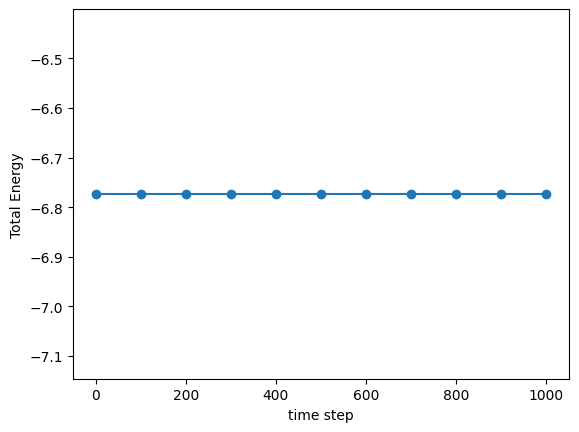

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel('time step')
plt.ylabel('Total Energy')
plt.plot(L.runs[0].thermo.Step, L.runs[0].thermo.TotEng,'-o')

# Tensile test of Aluminum

In [11]:
# https://github.com/nuwan-d/LAMMPS_tutorials_for_short_courses
lammps_in = """#

# ------------------------ INITIALIZATION ----------------------------

units 		metal
dimension	3
boundary	p	p	p
atom_style	atomic
variable 	latparam equal 4.0320


# ----------------------- ATOM DEFINITION----------------------------

lattice		fcc ${latparam}
region		whole block 0 10 0 10 0 10
create_box	1 whole
lattice 	fcc ${latparam} orient x 1 0 0 orient y 0 1 0 orient z 0 0 1
create_atoms	1 region whole


# ------------------------ FORCE FIELDS------------------------------

pair_style 	eam/alloy
pair_coeff 	* * Al_zhou.eam.alloy Al


# ------------------------EQUILIBRATION---------------------------------

variable 		tstp equal 0.001
timestep 		${tstp}
variable 		tdamp equal "v_tstp * 100"
variable 		pdamp equal "v_tstp * 1000"

fix		1 all nve
fix		2 all langevin 300.0 300.0 ${tdamp} 904297

thermo 	500
run 	10000

unfix 	1
unfix 	2

fix 	1 all npt temp 300 300 1 iso 0 0 1 drag 1

thermo 		200
thermo_style 	custom step lx ly lz press pxx pyy pzz pe temp

run 	10000
unfix 	1

variable 	tmp equal "lx"
variable 	L0 equal ${tmp}


# ------------------------DEFORMATION---------------------------------

reset_timestep	0
fix		1 all npt temp 300 300 ${tdamp} y 1 1 ${pdamp} z 1 1 ${pdamp} drag 1
variable 	srate equal 1.0e10
variable 	srate1 equal "v_srate / 1.0e12"
fix		2 all deform 1 x erate ${srate1} units box remap x


# ------------------------OUTPUTS---------------------------------

# for units metal, pressure is in [bars] = 100 [kPa] = 1/10000 [GPa]
# for units real, pressure is in [atm] = 101.325 [kPa] = 1.01325/10000 [GPa]

variable 	strain equal "(lx - v_L0)/v_L0"
variable 	p1 equal "-pxx/10000"
variable 	p2 equal "-pyy/10000"
variable 	p3 equal "-pzz/10000"

fix 	print all print 10 "${strain} ${p1} ${p2} ${p3}" file stress-strain.txt screen no

dump            2 all atom 200 tensile_test_movie.lammpstrj

thermo 	100
thermo_style	custom step temp v_strain v_p1 v_p2 v_p3 ke pe press

run		20000
"""
with open('eam_al_tesile.in', 'w') as f:
  f.write(lammps_in)

Note: Importance of DFT data to parametrize EAM

In [12]:
!wget https://www.ctcms.nist.gov/~knc6/DOWNLOADS/Al_zhou.eam.alloy

--2024-06-04 15:05:36--  https://www.ctcms.nist.gov/~knc6/DOWNLOADS/Al_zhou.eam.alloy
Resolving www.ctcms.nist.gov (www.ctcms.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to www.ctcms.nist.gov (www.ctcms.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 710486 (694K) [application/zip]
Saving to: ‘Al_zhou.eam.alloy’

Al_zhou.eam.alloy   100%[===================>] 693.83K  3.09MB/s    in 0.2s    

2024-06-04 15:05:36 (3.09 MB/s) - ‘Al_zhou.eam.alloy’ saved [710486/710486]



In [ ]:
# !wget https://figshare.com/ndownloader/files/42438840 -O Mishin-Ni-Al-2009.eam.alloy


In [13]:
!ls -altr

total 1780
-rw-r--r-- 1 root root 710486 Jun 22  2016 Al_zhou.eam.alloy
drwxr-xr-x 4 root root   4096 May 31 13:25 .config
drwxr-xr-x 1 root root   4096 May 31 13:30 sample_data
drwxr-xr-x 1 root root   4096 Jun  4 14:53 ..
-rw-r--r-- 1 root root  22537 Jun  4 14:55 condacolab_install.log
-rw-r--r-- 1 root root    502 Jun  4 15:00 lj_fluid.in
-rw-r--r-- 1 root root 825140 Jun  4 15:01 system.xyz
-rw-r--r-- 1 root root 228628 Jun  4 15:01 snapshot.png
-rw-r--r-- 1 root root   3737 Jun  4 15:01 log.lammps
-rw-r--r-- 1 root root   1938 Jun  4 15:05 eam_al_tesile.in
drwxr-xr-x 1 root root   4096 Jun  4 15:05 .


Takes about 30 minutes to run

In [14]:
%%time
!lmp -in eam_al_tesile.in

LAMMPS (7 Feb 2024 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 4.032 4.032 4.032
Created orthogonal box = (0 0 0) to (40.32 40.32 40.32)
  1 by 1 by 1 MPI processor grid
Lattice spacing in x,y,z = 4.032 4.032 4.032
Created 4000 atoms
  using lattice units in orthogonal box = (0 0 0) to (40.32 40.32 40.32)
  create_atoms CPU = 0.001 seconds
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 12.1025
  ghost atom cutoff = 12.1025
  binsize = 6.05125, bins = 7 7 7
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI

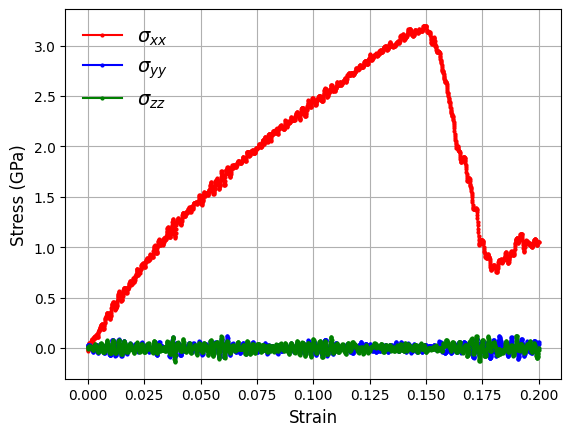

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Reading the data
with open('stress-strain.txt', 'r') as file:
    # Skip the header
    headings = file.readline().split()

    # Read the rest of the data
    data = np.loadtxt(file)

# Extract columns
strain = data[:, 0]
stress_xx = data[:, 1]
stress_yy = data[:, 2]
stress_zz = data[:, 3]

# Plotting
plt.figure()
plt.plot(strain, stress_xx, '-or', markersize=2, label='$\sigma_{xx}$')
plt.plot(strain, stress_yy, '-ob', markersize=2, label='$\sigma_{yy}$')
plt.plot(strain, stress_zz, '-og', markersize=2, label='$\sigma_{zz}$')

plt.xlabel('Strain', fontsize=12)
plt.ylabel('Stress (GPa)', fontsize=12)
plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')
plt.legend(fontsize=14, frameon=False)

plt.show()


In [16]:
!ls -altr tensile_test_movie.lammpstrj

-rw-r--r-- 1 root root 13651299 Jun  4 15:37 tensile_test_movie.lammpstrj


In [17]:
# https://www.cavs.msstate.edu/icme/code/lammps/atomistic_research/polymers/all_deformation.php
ch_meam="""# LAMMPS CH.meam file containing the MEAM CH parameters for saturated
# hydrocarbons developed by Sasan Nouranian.
# Reference: Physical Chemistry Chemical Physics, 16(13) (2014):6233-6249.
# This file is used together with the library.meam file.

rc = 3.000000
delta(1,2) = 2.120000
re(1,2) = 1.020000
delr = 0.1
alpha(1,2) = 3.200000
lattce(1,2) = dim
rho0(1) = 1.000000
rho0(2) = 1.800000
ialloy = 1
emb_lin_neg = 1
bkgd_dyn = 1
erose_form = 0
zbl(1,1) = -100
zbl(1,2) = -100
zbl(2,2) = -100
augt1 = 0
attrac(1,1) = 0.000000
repuls(1,1) = 0.000000
attrac(1,2) = 0.050000
repuls(1,2) = 0.050000
attrac(2,2) = 0.000000
repuls(2,2) = 0.050000
Cmin(1,1,1) = 2.000000
Cmax(1,1,1) = 2.800000
Cmin(1,1,2) = 2.000000
Cmax(1,1,2) = 2.800000
Cmin(1,2,1) = 0.445000
Cmax(1,2,1) = 2.800000
Cmin(1,2,2) = 1.500000
Cmax(1,2,2) = 2.000000
Cmin(2,2,1) = 0.520000
Cmax(2,2,1) = 2.200000
Cmin(2,2,2) = 0.750000
Cmax(2,2,2) = 2.800000
"""


lib_meam="""# LAMMPS library.meam file containing MEAM C and H parameters for saturated
# hydrocarbons developed by Sasan Nouranian.
# Reference: Physical Chemistry Chemical Physics, 16(13) (2014):6233-6249.
# This file is used together with the CH.meam file.

# elt        lat     z       ielement     atwt
# alpha      b0      b1      b2           b3    alat    esub    asub
# t0         t1              t2           t3            rozero  ibar

'C' 'dia' 4 6 12.011100
3.600000 4.200000 4.500000 4.300000 4.180000 3.325000 7.370000 0.640000
1.000000 0.500000 0.450000 -3.800000 1.000000 -5
'H' 'dim' 1 1 1.007900
2.038800 2.720000 2.045000 2.250000 3.000000 0.740000 2.363000 2.500000
1.000000 0.200000 -0.400000 0.000001 1.500000 -5
"""
data_in="""# nc1cl10

62 atoms
-2.377300 5.360300 xlo xhi
0.590000 21.363700 ylo yhi
-2.163700 3.024900 zlo zhi

2 atom types

Masses

1 12.0111
2 1.0079

Atoms

    1    1     1.000000     1.540000     0.000000
    2    1     2.456100     2.041400     0.000000
    3    1     1.538500     4.082700    -1.130600
    4    1     2.456100     3.581400     0.000000
    5    1     1.538500     5.622700    -1.130600
    6    1     0.370100     6.124100    -0.261600
    7    1     0.370100     7.664100    -0.261600
    8    1    -0.875500     8.165500     0.492500
    9    1    -0.875500     9.705500     0.492500
   10    1    -1.359100    10.206800    -0.881000
   11    1    -1.359100    11.746800    -0.881000
   12    1     0.095700    12.248200    -0.944400
   13    1     0.095700    13.788200    -0.944400
   14    1     1.468100    14.289600    -0.458000
   15    1     2.898200    16.331000    -0.183900
   16    1     1.468100    15.829600    -0.458000
   17    1     2.898200    17.871000    -0.183900
   18    1     3.201500    18.372300     1.240300
   19    1     4.452800    20.413700     1.985000
   20    1     3.201500    19.912300     1.240300
   21    2     1.000000     0.590000     0.000000
   22    2     0.480000     1.898100     0.900700
   23    2     0.480000     1.898100    -0.900700
   24    2     2.964000     1.666300    -0.900700
   25    2     2.964000     1.666300     0.900700
   26    2     1.910100     3.724600    -2.102000
   27    2     0.511400     3.724600    -0.966700
   28    2     2.076800     3.956500     0.962000
   29    2     3.475500     3.956500    -0.173300
   30    2     1.418200     5.980900    -2.163700
   31    2     2.493300     5.980900    -0.718200
   32    2     0.500100     5.749000     0.764300
   33    2    -0.575000     5.749000    -0.681200
   34    2     0.348500     8.022200    -1.301400
   35    2     1.281400     8.022200     0.239700
   36    2    -0.843600     7.790400     1.526100
   37    2    -1.776500     7.790400    -0.015000
   38    2     0.146800    10.063600     0.683900
   39    2    -1.552500    10.063600     1.282100
   40    2    -2.377300     9.831700    -1.061000
   41    2    -0.678100     9.831700    -1.659200
   42    2    -1.839400    12.105000     0.041600
   43    2    -1.917800    12.105000    -1.758200
   44    2     0.563900    11.873100    -1.866400
   45    2     0.642300    11.873100    -0.066600
   46    2    -0.695400    14.146300    -0.269100
   47    2    -0.093600    14.146300    -1.967100
   48    2     2.247700    13.914500    -1.137300
   49    2     1.646000    13.914500     0.560700
   50    2     3.239400    15.972800     0.798600
   51    2     3.578500    15.972800    -0.970600
   52    2     1.138800    16.204700    -1.438200
   53    2     0.799700    16.204700     0.331100
   54    2     1.908900    18.229100    -0.504900
   55    2     3.670800    18.229100    -0.880100
   56    2     4.188300    17.997200     1.549400
   57    2     2.426400    17.997200     1.924700
   58    2     4.452800    21.363700     1.985000
   59    2     4.439000    20.055600     3.024900
   60    2     5.360300    20.055600     1.476900
   61    2     3.225700    20.287400     0.206500
   62    2     2.304400    20.287400     1.754500
"""
lammps_in="""#Initialization

units metal
boundary s s s
atom_style atomic
read_data polymer.data

# Meam Potential for Saturated Hydrocarbons Information

pair_style meam
pair_coeff * * library.meam C H CH.meam C H

##################################################################################
#Minimization

minimize 0.0 1.0e-8 100000 100000

# Equilibration

reset_timestep 0
velocity 		all create 0.0 1231 dist gaussian
fix 			1 all nve
fix 			2 all langevin 0 0 0.001 904297
thermo_style 	custom step etotal press vol temp density pxx pyy pzz
thermo	  	100
timestep 		0.0003
run 			20000
unfix 1
unfix 2

######################################################################
# Deformation

run 0
reset_timestep 0

#Define Variables

variable 	yl equal "ylo+1"
variable 	yh equal "yhi-1"
variable 	yh2 equal "yhi*3"
variable 	y_step equal "yhi/2"

variable 	p3 equal "ly"
variable 	L0 equal ${p3}
variable 	strain equal "(ly - v_L0)/v_L0"
variable 	p1 equal v_strain
variable 	p2 equal "-pyy/10"

# define groups

region   	1 block INF INF INF ${yl} INF INF
group		wall region 1
region	2 block INF INF ${yh} INF INF INF
group		pull region 2
group		boundary union wall pull
group		mobile subtract all wall pull

# computes

compute peratom all stress/atom NULL pair

# initial velocities

velocity	mobile create 0.01 887723
velocity	pull set 0.0 .5 0.0
velocity	mobile ramp vy 0 ${y_step} y 0 ${yh2} sum yes

# fixes

fix	f1 all nve
fix 	ftemp all langevin 25 25 0.05 904297
fix	f2 boundary setforce NULL 0.0 0.0

# Dump
dump 100 all custom 1000 stress_per_atom.txt id type x y z c_peratom[1] c_peratom[2] c_peratom[3] c_peratom[4] c_peratom[5] c_peratom[6]
fix def1 all print 100 "${p1} ${p2}" file Stress_strain.def1.txt screen no

thermo_style custom step temp pyy lx ly lz v_strain
thermo 1000
timestep 0.0005
run   50000

print "All Done"




"""
with open('polymer.in', 'w') as f:
  f.write(lammps_in)
with open('polymer.data', 'w') as f:
  f.write(data_in)

with open('library.meam', 'w') as f:
  f.write(lib_meam)

with open('CH.meam', 'w') as f:
  f.write(ch_meam)

In [18]:
%%time
!lmp -in polymer.in

LAMMPS (7 Feb 2024 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Reading data file ...
  orthogonal box = (-2.3773 0.59 -2.1637) to (5.3603 21.3637 3.0249)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  62 atoms
  read_data CPU = 0.004 seconds
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 5
  ghost atom cutoff = 5
  binsize = 2.5, bins = 4 9 3
  2 neighbor lists, perpetual/occasional/extra = 2 0 0
  (1) pair meam, perpetual
      attributes: full, newton on
      pair build: full/bin/atomonly
      stencil: full/bin/3d
      bin: standard
  (2) pair meam, perpetual, half/full from (1)
      attributes: half, newton on
      pair build: halffull/newton
      stencil: none
      bin: none
Setting up cg style minimization ...
  Unit style    : metal
  Current step  : 0
Per MPI rank mem

In [19]:
!ls -altr

total 15600
-rw-r--r-- 1 root root   710486 Jun 22  2016 Al_zhou.eam.alloy
drwxr-xr-x 4 root root     4096 May 31 13:25 .config
drwxr-xr-x 1 root root     4096 May 31 13:30 sample_data
drwxr-xr-x 1 root root     4096 Jun  4 14:53 ..
-rw-r--r-- 1 root root    22537 Jun  4 14:55 condacolab_install.log
-rw-r--r-- 1 root root      502 Jun  4 15:00 lj_fluid.in
-rw-r--r-- 1 root root   825140 Jun  4 15:01 system.xyz
-rw-r--r-- 1 root root   228628 Jun  4 15:01 snapshot.png
-rw-r--r-- 1 root root     1938 Jun  4 15:05 eam_al_tesile.in
-rw-r--r-- 1 root root   149836 Jun  4 15:37 stress-strain.txt
-rw-r--r-- 1 root root 13651299 Jun  4 15:37 tensile_test_movie.lammpstrj
-rw-r--r-- 1 root root     1844 Jun  4 15:53 polymer.in
-rw-r--r-- 1 root root     3251 Jun  4 15:53 polymer.data
-rw-r--r-- 1 root root      724 Jun  4 15:53 library.meam
-rw-r--r-- 1 root root      919 Jun  4 15:53 CH.meam
drwxr-xr-x 1 root root     4096 Jun  4 15:54 .
-rw-r--r-- 1 root root    17633 Jun  4 15:54 Stress_strai

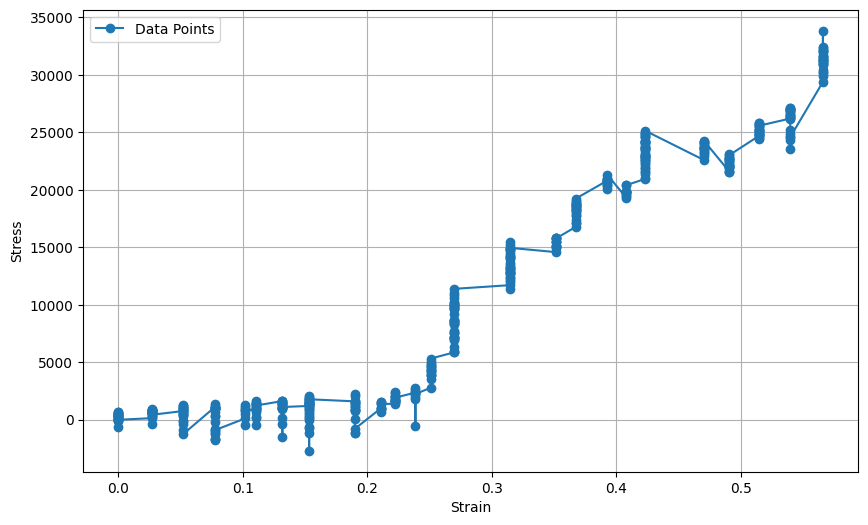

In [20]:
import matplotlib.pyplot as plt

# Initialize lists to store the data
x_values = []
y_values = []

# Read the data from the file
with open('Stress_strain.def1.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith('#'):
            continue
        parts = line.split()
        x_values.append(float(parts[0]))
        y_values.append(float(parts[1]))

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, 'o-', label='Data Points')
plt.ylabel('Stress')
plt.xlabel('Strain')

plt.legend()
plt.grid(True)
plt.show()
